# Lab 6: Word Sense Disambiguation

Lab session by:
* Daniel Hess
* Pandelis Laurens Symeonidis

### Imports

In [69]:
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.metrics.distance import jaccard_distance
from scipy.stats import pearsonr

from textserver import TextServer
import numpy as np
from nltk.corpus import stopwords 
import numpy as np

### Data Loading

In [80]:
nltk.download('wordnet')
nltk.download('omw-1.4')

nltk.download('stopwords', quiet=True)

# Load dataframes
dt = pd.read_csv('./STS.input.SMTeuroparl.txt', sep='\t', header=None)
gold_standard_dt = pd.read_csv('./STS.gs.SMTeuroparl.txt', sep='\t', header=None)

LIMIT = 10

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [71]:
def convert_category(word: str, penn_tag: str):
    d = {'NN': 'n', 'NNS': 'n',
          'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
            'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
            'RB': 'r', 'RBR': 'r', 'RBS': 'r'} 
    
    if penn_tag in d: 
        return word, d[penn_tag]
    else:
        return word, None 

def sentence_preparation(sentence: str):
    # Tokenize & optional simple filtering
    tokens = word_tokenize(sentence)

    # POS-tag (Penn)
    penn_tagged = nltk.pos_tag(tokens)

    # Map to WordNet POS and WSD
    context = tokens  # Contex =  the tokenized sentence
    items = []

    for (w, p) in penn_tagged:
        w2, wn_pos = convert_category(w, p)

        key = None
        if wn_pos is not None:
        
            syn = nltk.wsd.lesk(context, w, wn_pos)
            if syn is None:
                key = w
            else:
                key = syn.name()
        else:
            key = w

        items.append(key)

    return items

def lesk_similarities(dt):

    wsd1 = dt[0].apply(sentence_preparation)
    wsd2 = dt[1].apply(sentence_preparation)
    # print(wsd1.head())
    # print(wsd2.head())

    jaccard_distances_lesk = [jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(wsd1, wsd2)]
    similarities_lesk = [1 - d for d in jaccard_distances_lesk]

    return similarities_lesk, wsd1, wsd2

# Try 
# Lemmatize (lowers)
# remove punctuation
# regex preprocess
# lowercasing


In [81]:

def get_synset_from_textserver_result(x):
    if x[-1] == 'N/A':
        return x[0] # return token
    id = x[-1]
    pos, offset = id.split("-")
    pos = int(pos)
    synset = wn.synset_from_pos_and_offset(offset, pos)
    return synset.name()



def UKB_similarities(dt):
    ts = TextServer('pandelis4', '34E6z#NQD', 'senses')
    dt = dt.head(LIMIT)
    dt = dt.applymap(lambda sentence: ts.senses(sentence))

    dt_synsets = dt.applymap(lambda senses: [get_synset_from_textserver_result(x) for x in senses[0]])
    
    jaccard_distances = [jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(dt_synsets[0], dt_synsets[1])]
    similarities = [1 - d for d in jaccard_distances]

    return similarities, dt_synsets[0], dt_synsets[1]
    

In [82]:
similarities_lesk, synsets1_lesk, synsets2_lesk = lesk_similarities(dt.copy())
similarities_UKB, synsets1_UKB, synsets2_UKB = UKB_similarities(dt.copy())

/var/folders/2b/fv7ms52s1gn2cnglm3xf8grc0000gn/T/ipykernel_57287/2827068717.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dt = dt.applymap(lambda sentence: ts.senses(sentence))
/var/folders/2b/fv7ms52s1gn2cnglm3xf8grc0000gn/T/ipykernel_57287/2827068717.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dt_synsets = dt.applymap(lambda senses: [get_synset_from_textserver_result(x) for x in senses[0]])


Original first sentence:  The leaders have now been given a new chance and let us hope they seize it.
LESK first sentence:  ['The', 'leadership.n.02', 'have.v.01', 'now.r.01', 'be.v.01', 'give.v.05', 'a', 'new.a.01', 'probability.n.01', 'and', 'let.v.01', 'us', 'hope.v.01', 'they', 'assume.v.06', 'it', '.']
UKB first sentence:  ['The', 'leader.n.01', 'get.v.03', 'immediately.r.01', 'be.v.01', 'hold.v.03', 'a', 'new.a.06', 'opportunity.n.01', 'and', 'get.v.03', 'us', 'hope.v.02', 'they', 'seize.v.01', 'it', '.']
-----------------------
Original second sentence:  The leaders benefit aujourd' hui of a new luck and let's let them therefore seize it.
LESK second sentence:  ['The', 'leadership.n.02', 'profit.v.01', 'aujourd', "'", 'hui', 'of', 'a', 'new.a.01', 'luck.n.03', 'and', 'let.v.01', "'s", 'let.v.01', 'them', 'therefore.r.01', 'impound.v.01', 'it', '.']
UKB second sentence:  ['The', 'leader.n.01', 'benefit.v.02', 'aujourd', "'", 'hui', 'of', 'a', 'new.a.06', 'luck.n.02', 'and', 'perm

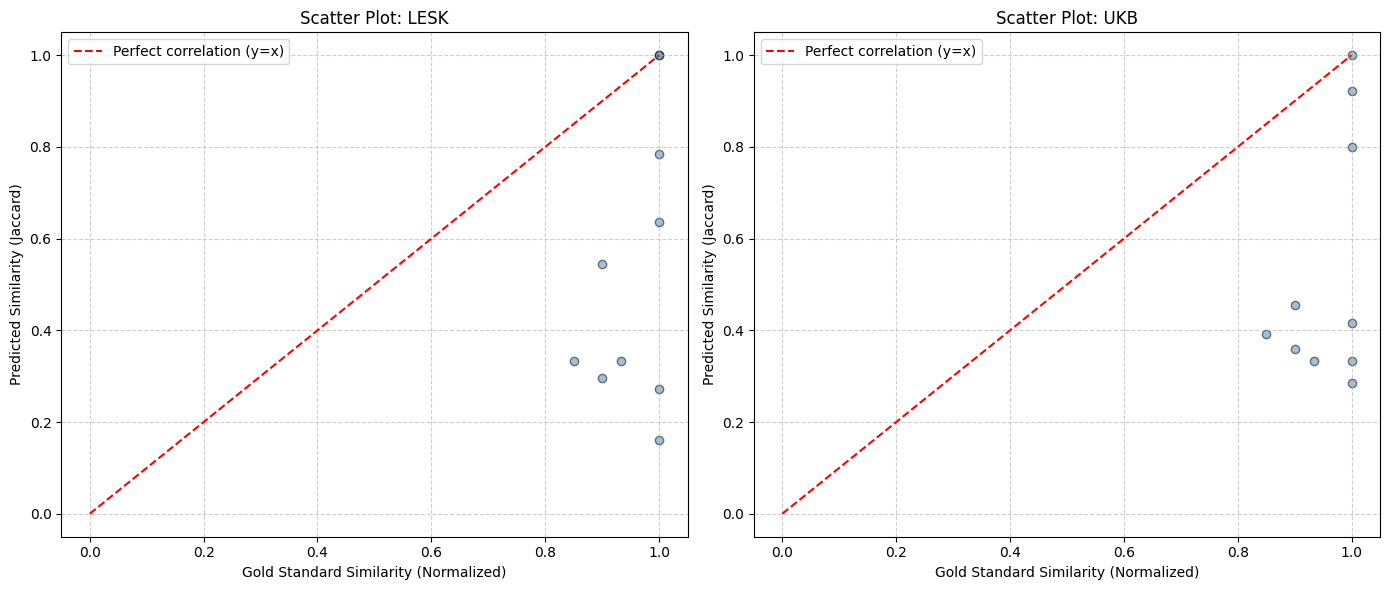

In [85]:
import matplotlib.pyplot as plt

print("Original first sentence: ", dt.iloc[0,0])
print("LESK first sentence: ", synsets1_lesk.iloc[0])
print("UKB first sentence: ", synsets1_UKB.iloc[0])
print("-----------------------")
print("Original second sentence: ", dt.iloc[0,1])
print("LESK second sentence: ", synsets2_lesk.iloc[0])
print("UKB second sentence: ", synsets2_UKB.iloc[0])

x = (gold_standard_dt[0]/5).values[:10]
print(len(similarities_UKB))

titles = [
    "LESK",
    "UKB"
]
ys = [
    similarities_lesk[:10],
    similarities_UKB[:10]
]

fig, ax_arr = plt.subplots(1, 2, figsize=(14, 6))

for ax, y, title in zip(ax_arr, ys, titles):
    y = np.array(y)
    ax.scatter(x, y, alpha=0.5, color="steelblue", edgecolor="k")
    ax.plot([0, 1], [0, 1], '--', color="red", label="Perfect correlation (y=x)")
    ax.set_xlabel("Gold Standard Similarity (Normalized)")
    ax.set_ylabel("Predicted Similarity (Jaccard)")
    ax.set_title(f"Scatter Plot: {title}")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()



# Analysis: LESK vs UKB Word Sense Disambiguation

In this lab, we compared the first 10 sentences in the SMTeuroparl text. Below we highlight some differences we found and do a comparison of the two models. As an example we use the following sentence:

**Original sentence:** "The leaders have now been given a new chance and let us hope they seize it."

#### Key Differences

1. **"leaders" → leadership vs leader**
   - **LESK**: `leadership.n.02` (abstract concept of leadership)
   - **UKB**: `leader.n.01` (concrete person who leads)
   - **Analysis**: LESK selected the abstract noun sense, while UKB chose the concrete noun. In the context "The leaders have...", "leaders" is more likely referring to people (leader.n.01), making UKB's choice more contextually appropriate.

2. **"have" → have vs get**
   - **LESK**: `have.v.01` (possess/own)
   - **UKB**: `get.v.03` (receive/obtain)
   - **Analysis**: In the phrase "have been given", "have" functions as an auxiliary verb in a passive construction. LESK's `have.v.01` (possess) is incorrect here—this is a grammatical auxiliary, not a lexical verb. UKB's `get.v.03` is also not ideal, but it captures the "receive" aspect better than "possess". Neither method correctly handles the auxiliary verb usage.

3. **"now" → now vs immediately**
   - **LESK**: `now.r.01` (temporal adverb - at the present time)
   - **UKB**: `immediately.r.01` (temporal adverb - without delay)
   - **Analysis**: Both are temporal adverbs, but `now.r.01` is more accurate for "now" in this context. `immediately.r.01` suggests urgency/instantaneity that isn't necessarily present in "now".


For this sentence, UKB demonstrates better semantic understanding. However, both methods have limitations, which is expected given their focus on lexical semantics rather than syntax.


In [86]:
corr_document = 0.462
corr_morphology = 0.489
corr_lesk = pearsonr(similarities_lesk, gold_standard_dt[0])[0] 

methods = ['Document-Level', 'Morphology', 'LESK',]
correlations = [corr_document, corr_morphology, corr_lesk]

print("\n" + "="*40)
print(" " * 10 + "PEARSON CORRELATION COMPARISON")
print("="*40)
print(f"\n{'Method':<20} {'Correlation':<15}")
print("-"*40)
for method, corr in zip(methods, correlations):
    print(f"{method:<20} {corr:<15.4f}")
print("-"*40)
print(f"\n{'Best Method:':<20} {methods[np.argmax(correlations)]}")
print(f"{'Best Correlation:':<20} {max(correlations):.4f}")
print("="*40 + "\n")




          PEARSON CORRELATION COMPARISON

Method               Correlation    
----------------------------------------
Document-Level       0.4620         
Morphology           0.4890         
LESK                 0.4071         
----------------------------------------

Best Method:         Morphology
Best Correlation:    0.4890



# Analysis

In this analysis we compare three different approaches to measuring sentence similarity using Jaccard distance, evaluated against the gold standard similarity scores from the SMTeuroparl dataset.

**1. Document-Level Approach (Lab 2)**
- **Best Configuration**: Lowercasing
- **Correlation**: r = 0.462
- **Method**: Simple Jaccard similarity on tokenized words with lowercasing

**2. Morphological Approach (Lab 3)**
- **Best Configuration**: Lemmatization + lowercasing
- **Correlation**: r = 0.489
- **Method**: Jaccard similarity on lemmatized tokens with lowercasing

**3. Semantic Approach (Lab 3 copy)**
- **LESK WSD**: Correlation r = 0.407
- **Method**: Jaccard similarity on WordNet synsets using LESK

#### Key Findings

The morphological approach (lemmatization + lowercasing) achieves the highest correlation (r = 0.489), over simple lowercase normalization (r = 0.462). LESK-based word sense disambiguation (r = 0.407) performs worse than both simpler approaches which was not what we expected. This result could be explained by:

1.  When WSD selects the wrong sense, it introduces noise. For example, in our analysis, LESK incorrectly identified "chance" as `probability.n.01` instead of `opportunity.n.01`. These errors reduce similarity scores for semantically similar sentences.

2. WordNet synsets are very fine-grained. Two sentences expressing the same meaning might use different synsets, leading Jaccard to treat them as not similar. For instance, "leader.n.01" and "leadership.n.02" are semantically related but counted as different when comparing synsets.


The better performance of document-level and morphological approach highlights the limitations of Jaccard similarity:

Even with WSD, Jaccard treats different synsets as completely different. Two sentences with the same meaning but different word choices or synsets will score low.

For Jaccard similarity, having the same words (or lemmas) is more important than having semantically same but lexically different words. 

Converting words to synsets increases the vocabulary space. If two sentences use different but semantically similar synsets, Jaccard similarity decreases. This explains why WSD  actually reduces correlation.

#### Ideas for Improvement

To achieve better similarity measurements we can try to:

1. **Better WSD**: Use better WSD methods that use WordNet relationships more effectively. For example using UKB on the entire dataset instead of LESK might produce better results as it is better as figuring out word senses as seen in our previous analysis of LESK vs UKB.

2. **Semantic similarity metrics**: Using metrics specifically designed for semantic similarity (e.g., Lin similarity, Path similarity) as explored in the previous lab.


#### Conclusion

The results show that the simpler approaches outperform the more complex semantic method when using the set-based similarity metric Jaccard. The morphological approach (lemmatization + lowercasing) achieves the best performance (r = 0.489), while word sense disambiguation actually degrades performance (r = 0.407) due to WSD errors and synset issues.